# measurement_error

> There are numerous problems that can occur when exogenous variables with measurment error are used in a regression model improperly. This notebook will demonstrate the problems that can occur when measurement error is present in the exogenous variables of a regression model. And some methods for mitigating the problems that can occur when measurement error is present in the exogenous variables of a regression model.

In [ ]:
#| default_exp measurement_error

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import xarray as xr

## Survey Data

When working with surveys and samples from a population, it is important to consider the precision of the population parameter estimates. The precision of the population parameter estimates is influenced by the sample size, the sampling design, and the measurement error in the survey data. 

When imprecise measures are used in a regression model, the estimates of the coefficients of the model will be biased and inconsistent. This can occur even when the sampling design is unbiased and respondents answers are entirely accurate. For survey data samples size is often limited, and the sampling design is often complex. This means that the measurement error in the survey data can have a significant impact on the precision of the population parameter estimates.

## Completely random measurement error in a binary outcome variable

Consider the following example:

> A survey is conducted weekly with an average of 500 participants each week. The survey asks participants if they recall seeing a particular brand's advertisement. Survey participents are randomly selected from the population and are well representative of the total population. The survey is conducted by phone and online.

First lets assume that all participants are able to recall the brand's advertisement with 100% accuracy. We would like to estimate the effect of a populations ability to recall the brand's advertisement on the brand's sales. We will use a simple linear regression model to estimate the effect of the populations ability to recall the brand's advertisement on the brand's sales.

Let us simulate the 3 years of survey data.


In [ ]:
#| export
def random_walk_awareness_model(
  periods: list | pd.DatetimeIndex | np.ndarray, # Time periods to simulate
  ) -> pm.Model: # PyMC model for the random walk awareness model
    coords = {
      'Period': periods,
    }
    with pm.Model(coords = coords) as model:
        #Random walk model
        weekly_variation = pm.HalfNormal('weekly_variation', sigma=.1)
        initial_awareness = pm.Normal('initial_awareness', mu=0, sigma=1)
        logit_awareness = pm.GaussianRandomWalk(
          'logit_awareness', 
          sigma=weekly_variation, 
          init_dist=pm.Normal.dist(mu=initial_awareness, sigma=.01), 
          dims="Period")
        
        weekly_shock = pm.HalfNormal('weekly_shock', sigma=.1)
        _noise = pm.Normal('_noise', mu=0, sigma=1, dims="Period")
        awareness = pm.Deterministic('awareness', pm.math.invlogit(logit_awareness + weekly_shock*_noise), dims="Period")
    return model

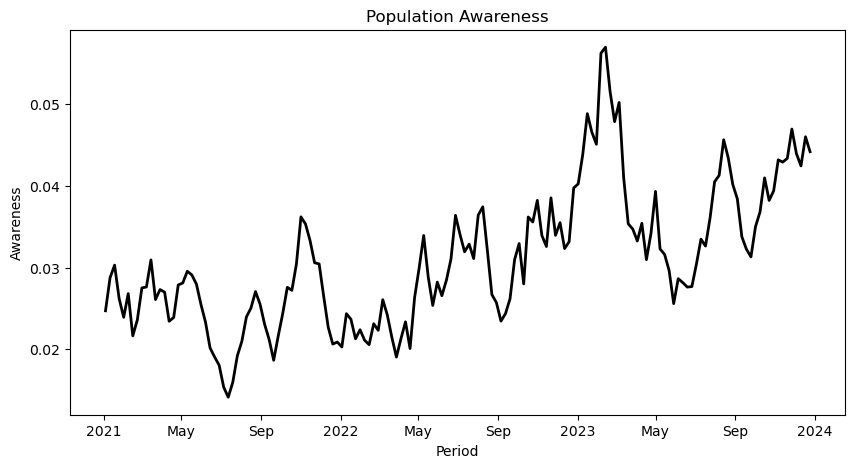

In [ ]:
dates = pd.date_range(start='2021-01-01', periods=156, freq='W-MON')
awareness_model = random_walk_awareness_model(dates)
starting_awareness = 0.025
logit_starting_awareness = np.log(starting_awareness/(1-starting_awareness))
generative_model = pm.do(
  awareness_model, 
  {
    'weekly_variation': .1, 
    'initial_awareness': logit_starting_awareness,
    'weekly_shock': .01
  }
)
population_awareness = pm.draw(generative_model['awareness'], random_seed=42)
population_awareness = xr.DataArray(
  population_awareness,
  dims=['Period'],
  coords={'Period': dates}
)
plt.figure(figsize=(10, 5))
population_awareness.plot(c='k', lw=2)
plt.title('Population Awareness')
plt.ylabel('Awareness')
plt.xlabel('Period');

In [ ]:
#| export
def survey_obs_model(
  population_awareness: xr.DataArray | pm.pytensorf.TensorVariable, # Population awareness
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  coords: dict = None, # Coordinates for the PyMC model
  model: pm.Model = None, # PyMC model to add the survey observation model
  ) -> pm.Model:
    if coords is None:
      assert isinstance(population_awareness, xr.DataArray), "If coords is not provided, population_awareness must be an xarray DataArray"
      coords = {
        'Period': population_awareness['Period'].values,
      }
      population_awareness = population_awareness.values
    try:
      model = pm.modelcontext(model)
    except TypeError:
      model = pm.Model(coords=coords)
    with model:
        N_survey_participant = pm.Poisson('n_survey_participants', avg_weekly_participants, dims="Period")
        N_positive = pm.Binomial('n_positive', N_survey_participant, population_awareness, dims="Period")
    return model

In [ ]:
#| export
def simulate_awareness_survey_data(
  start_date: str = '2020-01-01', # Start date of the survey data
  n_weeks: int = 156, # Number of weeks to simulate
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  weekly_awareness_variation: float = 0.08, # Std. dev. of gaussian inovations for weekly awareness
  starting_population_aware: float = 0.025, # Starting population awareness
  weekly_shock: float = 0.01, # Std. dev. of gaussian noise for weekly deviation from random walk
  random_seed: int = 42, # Random seed for reproducibility
) -> xr.Dataset: # Simulated awareness survey data as an xarray dataset
  dates = pd.date_range(start=start_date, periods=n_weeks, freq='W-MON')
  awareness_model = random_walk_awareness_model(dates)
  gen_model = pm.do(
    awareness_model, 
    {
      'weekly_variation': weekly_awareness_variation, 
      'initial_awareness': np.log(starting_population_aware/(1-starting_population_aware)),
      'weekly_shock': .01
    }
  )
  
  with gen_model:
    survey_obs_model(gen_model['awareness'], avg_weekly_participants=avg_weekly_participants, coords={'Period': dates})
    trace = pm.sample_prior_predictive(1, random_seed=random_seed)
  
  trace = trace.prior.isel(chain=0, draw=0).drop_vars('chain').drop_vars('draw')
  return trace.assign(estimated_awareness = trace['n_positive']/trace['n_survey_participants'])


In [ ]:
#| export
def plot_survey_sim_data(
  data: xr.Dataset, # Simulated survey data must contain 'awareness' and 'estimated_awareness' variables
) -> None: # Plot of the simulated survey data
    plt.figure(figsize=(10, 5))
    data.estimated_awareness.plot.scatter(x='Period', c='lightblue', label='Simulated Survey Data')
    data.awareness.plot(c='k', lw=2, ls='--', label="Population Awareness")
    plt.legend()
    plt.title('Simulated Awareness Survey Data');

Sampling: [_noise, logit_awareness, n_positive, n_survey_participants]


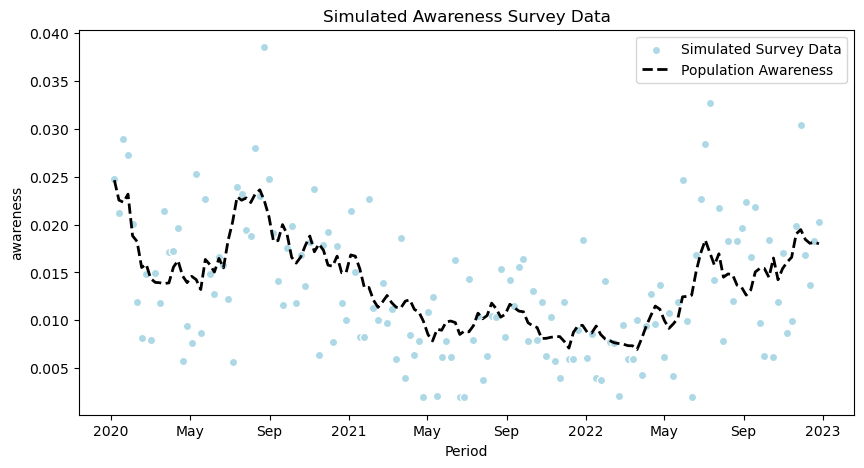

In [ ]:
trace = simulate_awareness_survey_data(random_seed=23)
plot_survey_sim_data(trace)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()